In [340]:
# Parameters

file_path = 'data/PPG2 18.04.2024 at 11:05.bin'
#file_path = 'data/PPG2 18.04.2024 at 15:35.bin'
#file_path = 'data/PPG2 18.04.2024 at 16:35.bin'


samples_to_strip = 15 * 30  # 15 seconds * 30 Hz
sample_amount = 20 * 30 # 20 seconds * 30 Hz

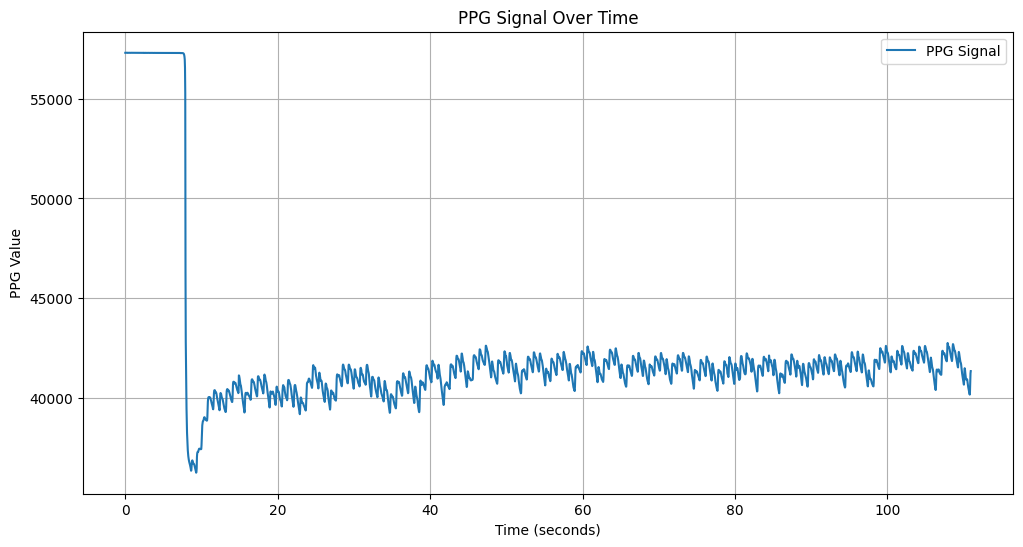

In [341]:
## %matplotlib notebook


import numpy as np
import matplotlib.pyplot as plt

# Load the binary file

data = -np.fromfile(file_path, dtype=np.uint16)

# Create a time axis in seconds (data sampled at 30 Hz)
time = np.arange(len(data)) / 30.0

# Plot the PPG data
plt.figure(figsize=(12, 6))
plt.plot(time, data, label='PPG Signal')
plt.xlabel('Time (seconds)')
plt.ylabel('PPG Value')
plt.title('PPG Signal Over Time')
plt.legend()
plt.grid(True)
plt.show()

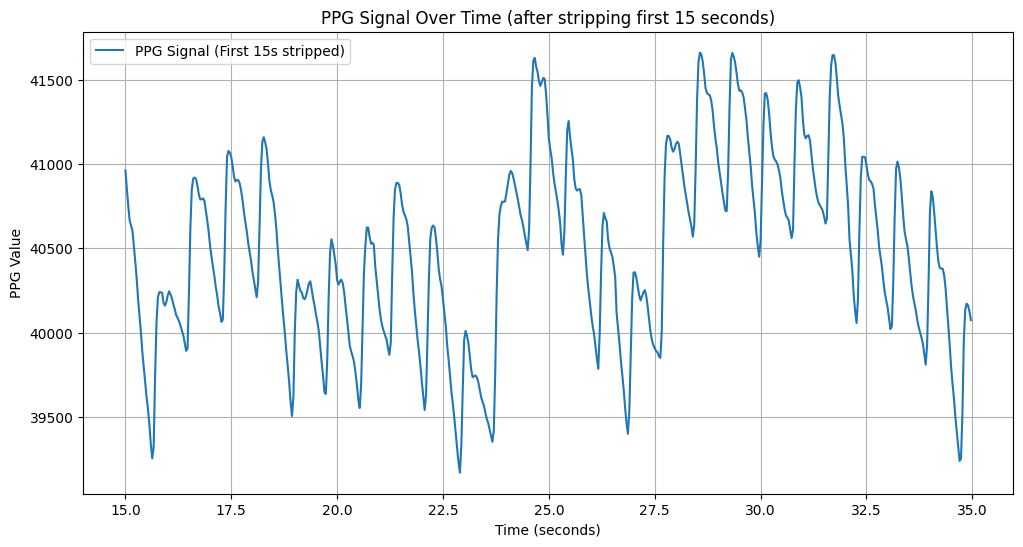

In [342]:
stripped_data = data[samples_to_strip:samples_to_strip+sample_amount]
stripped_time = time[samples_to_strip:samples_to_strip+sample_amount]

# Plot the stripped PPG data
plt.figure(figsize=(12, 6))
plt.plot(stripped_time, stripped_data, label='PPG Signal (First 15s stripped)')
plt.xlabel('Time (seconds)')
plt.ylabel('PPG Value')
plt.title('PPG Signal Over Time (after stripping first 15 seconds)')
plt.legend()
plt.grid(True)
plt.show()

In [343]:
# Normalize the PPG data (subtract mean and divide by standard deviation)

# Calculate the mean and standard deviation of the PPG data
mean_data = np.mean(stripped_data)
std_data = np.std(stripped_data)

# Normalize the PPG data
normalized_data = (stripped_data - mean_data) #/ std_data


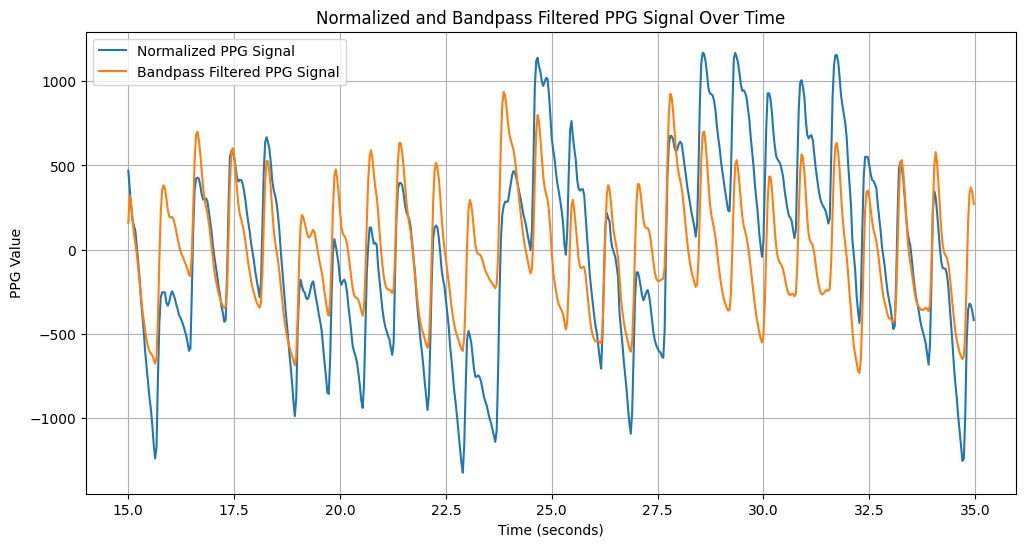

In [344]:
from scipy.signal import butter, lfilter

def butter_bandpass(lowcut, highcut, fs, order=5):
    return butter(order, [lowcut, highcut], fs=fs, btype='band')

def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = lfilter(b, a, data)
    return y


# Define the bandpass filter parameters
lowcut = 0.5  # Low frequency bound in Hz
highcut = 5  # High frequency bound in Hz
fs = 30.0  # Sampling frequency in Hz
order = 1  # Filter order

# Filter the PPG data
filtered_data = butter_bandpass_filter(normalized_data, lowcut, highcut, fs, order=order)

# Plot both the normalized and filtered PPG data
plt.figure(figsize=(12, 6))
plt.plot(stripped_time, normalized_data, label='Normalized PPG Signal')
plt.plot(stripped_time, filtered_data, label='Bandpass Filtered PPG Signal')
plt.xlabel('Time (seconds)')
plt.ylabel('PPG Value')
plt.title('Normalized and Bandpass Filtered PPG Signal Over Time')
plt.legend()
plt.grid(True)
plt.show()


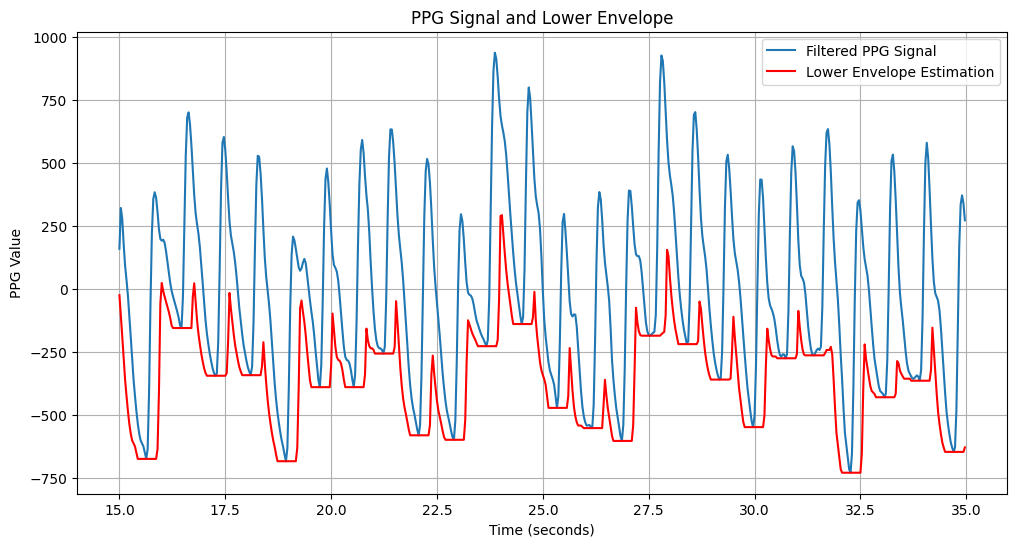

In [345]:
def minimum_filter(data, window_size):
    n = len(data)
    output = np.zeros(n)
    for i in range(n):
        start_index = max(i - window_size // 2, 0)
        end_index = min(i + window_size // 2, n)
        output[i] = np.min(data[start_index:end_index])
    return output

window_width = int(0.5 * fs)  # 0.5 seconds * 30 Hz

lower_envelope_est = minimum_filter(filtered_data, window_width)

# Plot the original filtered signal and the estimated lower envelope
plt.figure(figsize=(12, 6))
plt.plot(stripped_time, filtered_data, label='Filtered PPG Signal')
plt.plot(stripped_time, lower_envelope_est, label='Lower Envelope Estimation', color='red')
plt.xlabel('Time (seconds)')
plt.ylabel('PPG Value')
plt.title('PPG Signal and Lower Envelope')
plt.legend()
plt.grid(True)
plt.show()



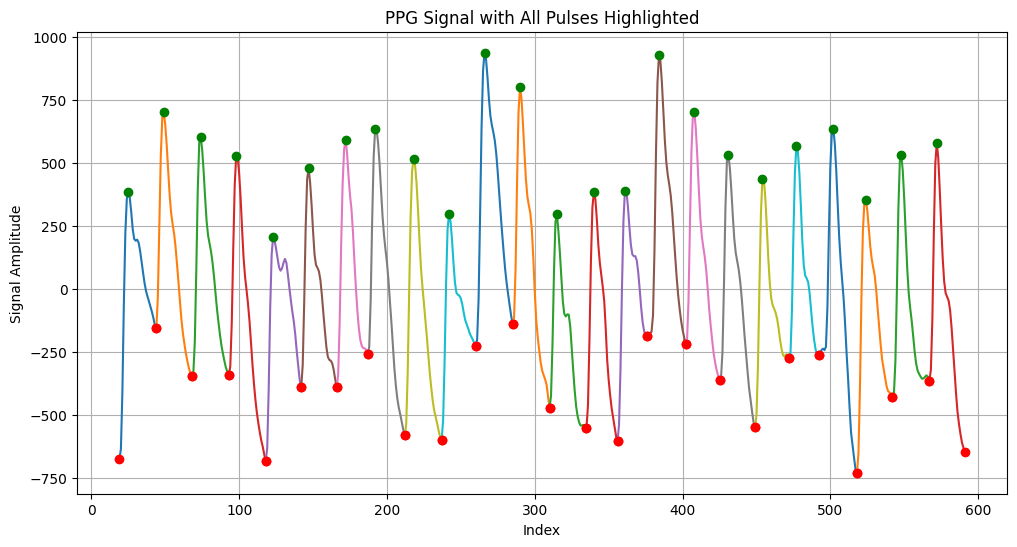

In [346]:
import numpy as np
import matplotlib.pyplot as plt

class Pulse:
    def __init__(self, signal, start_trough_index, peak_index, end_trough_index):
        self.signal = signal
        self.start_trough_index = start_trough_index
        self.peak_index = peak_index
        self.end_trough_index = end_trough_index
    
    def get_pulse_data(self):
        """Returns the slice of the signal for this pulse."""
        return self.signal[self.start_trough_index:self.end_trough_index + 1]

    def plot_pulse(self, ax):
        """Plot the pulse on the provided Axes object."""
        time_indices = range(self.start_trough_index, self.end_trough_index + 1)
        ax.plot(time_indices, self.get_pulse_data(), label=f'Pulse from {self.start_trough_index} to {self.end_trough_index}')
        ax.plot(self.peak_index, self.signal[self.peak_index], 'go')  # Mark the peak
        ax.plot([self.start_trough_index, self.end_trough_index], [self.signal[self.start_trough_index], self.signal[self.end_trough_index]], 'ro')  # Mark the troughs
        
    def amplitude(self):
        """Returns the amplitude of the pulse."""
        return self.signal[self.peak_index] - self.signal[self.start_trough_index]

    def trough_depth_difference(self):
        """Returns the depth difference between the end and start trough."""
        return self.signal[self.end_trough_index] - self.signal[self.start_trough_index]

    def pulse_width(self, fs):
        """Returns the pulse width based on the sampling frequency."""
        return (self.end_trough_index - self.start_trough_index) / fs


def find_troughs_from_envelope(signal, envelope):
    # Identify troughs as points where the signal matches the lower envelope
    return np.where(signal == envelope)[0]

def find_peaks(signal, trough_indices):
    # Find the maximum (peak) value between consecutive troughs
    peak_indices = []
    for i in range(len(trough_indices) - 1):
        start, end = trough_indices[i], trough_indices[i + 1]
        peak_index = np.argmax(signal[start:end+1]) + start
        peak_indices.append(peak_index)
    return peak_indices

# Example usage:
trough_indices = find_troughs_from_envelope(filtered_data, lower_envelope_est)
peak_indices = find_peaks(filtered_data, trough_indices)

# Create a figure and axes for plotting
fig, ax = plt.subplots(figsize=(12, 6))

# Creating and plotting all Pulse objects on the same plot
pulses = [Pulse(filtered_data, trough_indices[i], peak_indices[i], trough_indices[i + 1]) for i in range(len(peak_indices))]
for pulse in pulses:
    pulse.plot_pulse(ax)

ax.set_xlabel('Index')
ax.set_ylabel('Signal Amplitude')
ax.set_title('PPG Signal with All Pulses Highlighted')
ax.grid(True)
plt.show()


In [347]:


amplitude_values = [pulse.amplitude() for pulse in pulses]
amplitude_min_threshold = 20
amplitude_max_threshold = 2000

trough_depth_values = [pulse.trough_depth_difference() for pulse in pulses]
trough_depth_difference_min_threshold = -250
trough_depth_difference_max_threshold = 250

pulse_width_values = [pulse.pulse_width(fs) for pulse in pulses]
pulse_width_min_threshold = 0.5
pulse_width_max_threshold = 1

amplitude_values, trough_depth_values, pulse_width_values


([1058.6322573209086,
  856.1720831088498,
  947.9048892477022,
  871.0650306575454,
  891.9415228684265,
  868.1380776129229,
  981.459702772948,
  890.2685367893738,
  1097.4104346887902,
  895.4663862880536,
  1165.0357551457296,
  939.0482613118216,
  770.0827597123312,
  937.125658501628,
  994.1028573911576,
  1112.3962223842404,
  921.1332315488118,
  892.4664608665821,
  983.012417735991,
  841.5996470650326,
  898.2857449462199,
  1081.7840729719846,
  963.0786464041072,
  944.5222623578279],
 [519.5102002458116,
  -189.4233068491282,
  2.2847921215856672,
  -341.64772826105605,
  294.03056739766447,
  0.046238126719288175,
  133.27015290607312,
  -324.46319753677597,
  -17.78763222336022,
  371.6119565469666,
  87.92302321541436,
  -332.81524588566583,
  -80.32331581381419,
  -50.912537369023084,
  417.7575341527222,
  -33.445226663208814,
  -140.74879307343244,
  -188.70216125347991,
  273.2382048475175,
  11.6827141362416,
  -465.99390784293024,
  299.6611000604113,
  65.61

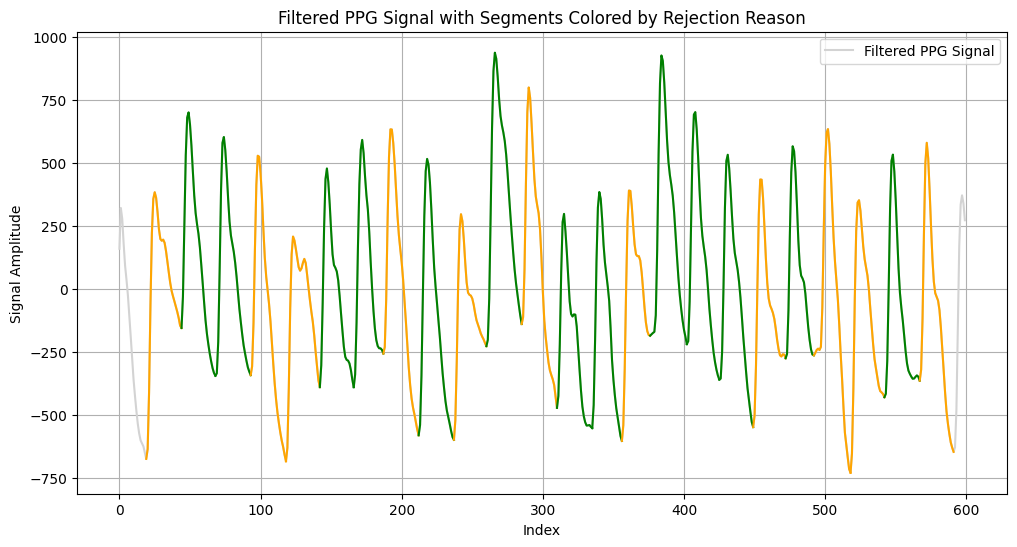

In [348]:
# Calculate the validity for each characteristic
amplitude_valid = [(amplitude_min_threshold <= value <= amplitude_max_threshold) for value in amplitude_values]
trough_depth_valid = [(trough_depth_difference_min_threshold <= value <= trough_depth_difference_max_threshold) for value in trough_depth_values]
pulse_width_valid = [(pulse_width_min_threshold <= value <= pulse_width_max_threshold) for value in pulse_width_values]

# Initialize validity checks and plot setup
valid_indices = []
plt.figure(figsize=(12, 6))
plt.plot(filtered_data, label='Filtered PPG Signal', color='lightgray')

# Iterate over pulses and check validity
for i, pulse in enumerate(pulses):
    start, end = pulse.start_trough_index, pulse.end_trough_index
    valid = True  # Assume segment is valid unless a check fails

    # Check each condition
    if not amplitude_valid[i]:
        segment_color = 'red'  # Amplitude invalid
        valid = False
    elif not trough_depth_valid[i]:
        segment_color = 'orange'  # Trough depth invalid
        valid = False
    elif not pulse_width_valid[i]:
        segment_color = 'magenta'  # Pulse width invalid
        valid = False
    else:
        segment_color = 'green'  # Valid segment

    # Only store indices of valid segments
    if valid:
        valid_indices.append(i)

    # Plot the pulse segment with the determined color
    plt.plot(range(start, end + 1), filtered_data[start:end + 1], color=segment_color)

plt.xlabel('Index')
plt.ylabel('Signal Amplitude')
plt.title('Filtered PPG Signal with Segments Colored by Rejection Reason')
plt.grid(True)
plt.legend()
plt.show()

/var/folders/yb/3195fdfn2vb_j67t_92p2yzw0000gn/T/ipykernel_64412/1480695947.py:33: RuntimeWarning: Mean of empty slice
  mean_pulse = np.nanmean(np.vstack(aligned_pulses), axis=0)


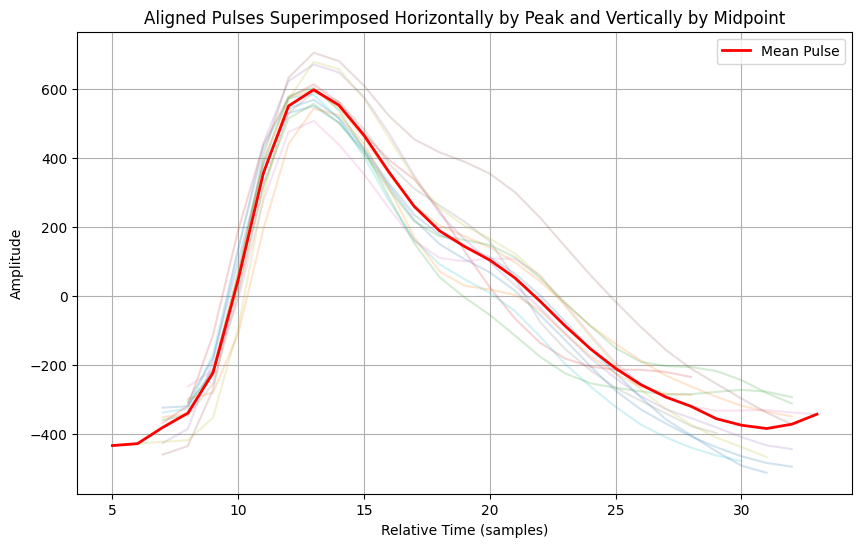

In [349]:
def align_pulses(pulses, fs):
    max_pulse_width = 0
    aligned_pulses = []
    vertical_offsets = []

    # Calculate necessary alignments and vertical offsets
    for pulse in pulses:
        pulse_data = pulse.get_pulse_data()
        pulse_length = len(pulse_data)
        peak_position_in_pulse = pulse.peak_index - pulse.start_trough_index
        midpoint_amplitude = (pulse.signal[pulse.peak_index] + pulse.signal[pulse.start_trough_index]) / 2
        max_pulse_width = max(max_pulse_width, pulse_length)
        vertical_offsets.append(midpoint_amplitude)
    
    average_midpoint_amplitude = np.mean(vertical_offsets)

    # Align all pulses horizontally and vertically
    for pulse in pulses:
        pulse_data = pulse.get_pulse_data()
        peak_position_in_pulse = pulse.peak_index - pulse.start_trough_index
        padding_before = max(max_pulse_width // 2 - peak_position_in_pulse, 0)
        offset_after = max(2 * max_pulse_width - (padding_before + len(pulse_data)), 0)
        aligned_pulse = np.pad(pulse_data, (padding_before, offset_after), 'constant', constant_values=(np.nan, np.nan))
        vertical_shift = average_midpoint_amplitude - (pulse.signal[pulse.peak_index] + pulse.signal[pulse.start_trough_index]) / 2
        aligned_pulse += vertical_shift
        aligned_pulses.append(aligned_pulse)
    
    return aligned_pulses

# Usage of the function with valid pulses
valid_pulses = [pulses[i] for i in valid_indices]
aligned_pulses = align_pulses(valid_pulses, fs)
mean_pulse = np.nanmean(np.vstack(aligned_pulses), axis=0)


plt.figure(figsize=(10, 6))
for pulse in aligned_pulses:
    plt.plot(pulse, alpha=0.2)  # Partial transparency to visualize overlap

plt.plot(mean_pulse, color='red', linewidth=2, label='Mean Pulse')
plt.title('Aligned Pulses Superimposed Horizontally by Peak and Vertically by Midpoint')
plt.xlabel('Relative Time (samples)')
plt.ylabel('Amplitude')
plt.grid(True)
plt.legend()
plt.show()

/var/folders/yb/3195fdfn2vb_j67t_92p2yzw0000gn/T/ipykernel_64412/540107097.py:18: RuntimeWarning: Mean of empty slice
  mean_pulse = np.nanmean(np.vstack(aligned_pulses), axis=0)


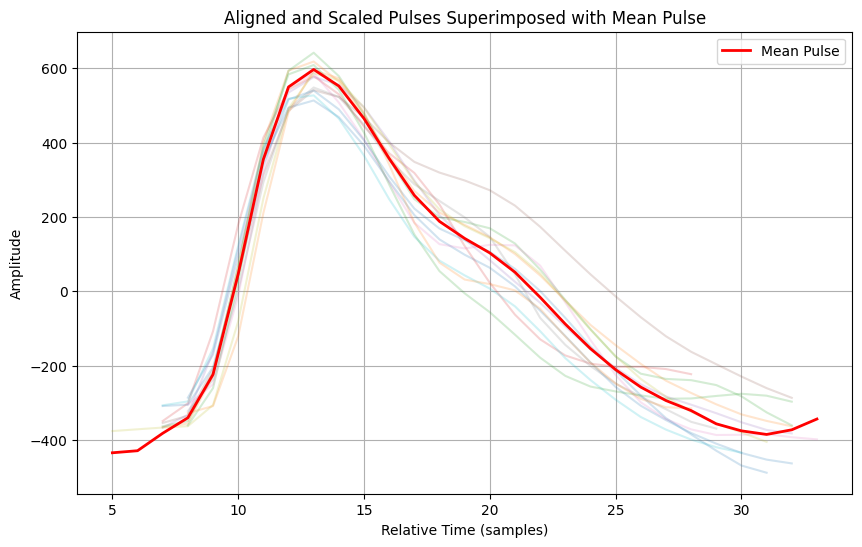

In [350]:
def scale_pulses_to_minimize_difference(pulses, mean_pulse):
    scaled_pulses = []
    scaling_factors = []

    for pulse in pulses:
        # Only consider non-NaN values for calculation
        valid_indices = ~np.isnan(pulse)
        valid_pulse = pulse[valid_indices]
        valid_mean_pulse = mean_pulse[valid_indices]

        # Calculate the optimal scaling factor using the dot product
        scale_factor = np.dot(valid_pulse, valid_mean_pulse) / np.dot(valid_pulse, valid_pulse)
        scaled_pulses.append(pulse * scale_factor)
        scaling_factors.append(scale_factor)

    return scaled_pulses, scaling_factors

mean_pulse = np.nanmean(np.vstack(aligned_pulses), axis=0) 
scaled_pulses, scaling_factors = scale_pulses_to_minimize_difference(aligned_pulses, mean_pulse)

# Plotting scaled pulses
plt.figure(figsize=(10, 6))
for pulse, factor in zip(scaled_pulses, scaling_factors):
    plt.plot(pulse, alpha=0.2)

plt.plot(mean_pulse, color='red', linewidth=2, label='Mean Pulse')
plt.title('Aligned and Scaled Pulses Superimposed with Mean Pulse')
plt.xlabel('Relative Time (samples)')
plt.ylabel('Amplitude')
plt.legend()
plt.grid(True)
plt.show()

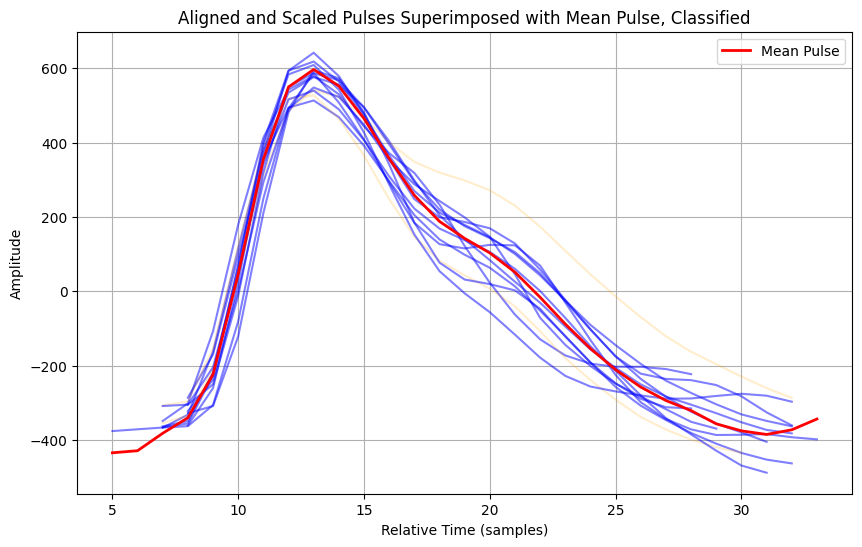

In [351]:
def classify_pulses(pulses, mean_pulse, threshold):
    classifications = []
    differences = []

    for pulse in pulses:
        # Calculate absolute difference from the mean pulse, ignoring NaNs
        valid_indices = ~np.isnan(pulse)
        difference = np.abs(pulse[valid_indices] - mean_pulse[valid_indices])
        mean_difference = np.mean(difference)

        # Compare mean difference to threshold and classify
        if mean_difference <= threshold:
            classifications.append("Good")
        else:
            classifications.append("Bad")
        
        differences.append(mean_difference)

    return classifications, differences

difference_threshold = 75  # Adjust this value based on your specific requirements and data scale

# Classify the pulses
classifications, mean_differences = classify_pulses(scaled_pulses, mean_pulse, difference_threshold)

# Plotting results with classification
plt.figure(figsize=(10, 6))
colors = {'Good': 'blue', 'Bad': 'orange'}
alpha_values = {'Good': 0.5, 'Bad': 0.2}
for pulse, classification in zip(scaled_pulses, classifications):
    plt.plot(pulse, alpha=alpha_values[classification], color=colors[classification])

plt.plot(mean_pulse, color='red', linewidth=2, label='Mean Pulse')
plt.title('Aligned and Scaled Pulses Superimposed with Mean Pulse, Classified')
plt.xlabel('Relative Time (samples)')
plt.ylabel('Amplitude')
plt.legend()
plt.grid(True)
plt.show()